# Parse Optode


In [1]:
source('source.r')

Packages Loaded:
ncdf4 R.matlab openxlsx RColorBrewer compiler lattice geosphere readxl data.table rworldmap rworldxtra


Loading required package: ncdf4
Loading required package: R.matlab
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘R.matlab’”Loading required package: openxlsx
Loading required package: RColorBrewer
Loading required package: compiler
Loading required package: lattice
Loading required package: geosphere
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘geosphere’”Loading required package: readxl
Loading required package: data.table
Loading required package: rworldmap
Loading required package: sp
### Welcome to rworldmap ###
For a short introduction type : 	 vignette('rworldmap')
Loading required package: rworldxtra


In [2]:
input.dir = 'Raw Data/O2-optode MIMS/'

file.list = list.files(input.dir)
file.list = file.list[!grepl('.xlsx', file.list)]
file.list = file.list[grepl('.txt', file.list)]
length(file.list)

[1] 44

In [3]:
process.file = function(input.dir, file) {
    data = data.frame(Date = '', Time = '', Rel.Time = '',
                      Oxy.ch1 = 0, Oxy.ch2 = 0, Oxy.ch3 = 0, Oxy.ch4 = 0,
                      Temp.ch1 = 0, Temp.ch2 = 0, Temp.ch3 = 0, Temp.ch4 = 0, Pressure = 0, stringsAsFactors = FALSE)
    
    temp = fread(paste0(input.dir, file), skip = 20, sep = '\t')[,c(1:3, 5:13)]
    colnames(temp) = colnames(data)
    data = rbind(data, temp)
    data = data[-1,]
    data = data[,-3]
    data = as.data.frame(data)
    
    for (i in 3:ncol(data)) {
        data[,i] = as.numeric(data[,i])
    }
    
    data$Time = add.time(data$Date, data$Time)
    data
}

add.time = function(dates, times) {
    ans = as.POSIXct('5/16/2017 14:07:10', format = '%m/%d/%Y %H:%M:%S', tz = 'GMT')
    if (grepl('2017', dates[2])) {
        format = '%m/%d/%Y %H:%M:%S'
    } else {
        format = '%m/%d/%y %H:%M:%S'
    }
    for (i in 1:length(dates)) {
        ans = c(ans, as.POSIXct(paste(dates[i], times[i]), format = format, tz = 'GMT'))
    }
    ans = ans[-1]
    ans
}

avg.data = function(data, N = 60, time.as.char = FALSE) {
    i = 1
    
    #for (j in 2:ncol(data)) {
    #    data[,j] = as.numeric(data[,j])
    #}
    
    while (i < nrow(data)) {
        dt = as.numeric(difftime(data$Time, data$Time[i], unit = 'secs'))
        l = which(dt >= 0 & dt < N)
        
        ## Dataset to be averaged.
        temp = data[l,]
        
        ## Take average of each field (couldn't find a more elegant solution)
        temp$Oxy.ch1 = mean(temp$Oxy.ch1[temp$Oxy.ch1.flag == 1], na.rm = TRUE)
        temp$Oxy.ch2 = mean(temp$Oxy.ch2[temp$Oxy.ch2.flag == 1], na.rm = TRUE)
        temp$Oxy.ch3 = mean(temp$Oxy.ch3[temp$Oxy.ch3.flag == 1], na.rm = TRUE)
        temp$Oxy.ch4 = mean(temp$Oxy.ch4[temp$Oxy.ch4.flag == 1], na.rm = TRUE)
        
        temp$Temp.ch1 = mean(temp$Temp.ch1[temp$Temp.ch1.flag == 1], na.rm = TRUE)
        temp$Temp.ch2 = mean(temp$Temp.ch2[temp$Temp.ch2.flag == 1], na.rm = TRUE)
        temp$Temp.ch3 = mean(temp$Temp.ch3[temp$Temp.ch3.flag == 1], na.rm = TRUE)
        temp$Temp.ch4 = mean(temp$Temp.ch4[temp$Temp.ch4.flag == 1], na.rm = TRUE)
        
        temp$Pressure = mean(temp$Pressure[temp$Pressure.flag == 1], na.rm = TRUE)

        ## Save average value
        data[i,] = temp[1,]
        
        if (length(l) > 1) {
            l = l[l != i]
            if (length(l) > 0) {
                data = data[-l,]
            }
        }
        i = i + 1
    }
    if (time.as.char) {
        data$Time = as.character(data$Time, tz = 'GMT')
    }
    data
}

plot.flags = function(data, file) {
    
    data[is.na(data)] = 0
    pdf(file)
    
    par(mfrow=c(2,2))
    plot(data$Time, data$Oxy.ch1, pch=20, cex=0.1, col = data$Oxy.ch1.flag, main = 'Ch 1 Oxygen', ylab='', xlab='')
    plot(data$Time, data$Oxy.ch2, pch=20, cex=0.1, col = data$Oxy.ch2.flag, main = 'Ch 2 Oxygen', ylab='', xlab='')
    plot(data$Time, data$Oxy.ch3, pch=20, cex=0.1, col = data$Oxy.ch3.flag, main = 'Ch 3 Oxygen', ylab='', xlab='')
    plot(data$Time, data$Oxy.ch4, pch=20, cex=0.1, col = data$Oxy.ch4.flag, main = 'Ch 4 Oxygen', ylab='', xlab='')
    
    plot(data$Time, data$Temp.ch1, pch=20, cex=0.1, col = data$Temp.ch1.flag, main = 'Ch 1 Temperature',
         ylab='', xlab='')
    plot(data$Time, data$Temp.ch2, pch=20, cex=0.1, col = data$Temp.ch2.flag, main = 'Ch 2 Temperature',
         ylab='', xlab='')
    plot(data$Time, data$Temp.ch3, pch=20, cex=0.1, col = data$Temp.ch3.flag, main = 'Ch 3 Temperature',
         ylab='', xlab='')
    plot(data$Time, data$Temp.ch4, pch=20, cex=0.1, col = data$Temp.ch4.flag, main = 'Ch 4 Temperature',
         ylab='', xlab='')
    dev.off()
}



add.filter.flags = function(data) {
    data$Oxy.ch1.flag = filter.outliers(data$Oxy.ch1, n = 60, tol = 3)
    data$Oxy.ch2.flag = filter.outliers(data$Oxy.ch2, n = 60, tol = 3)
    data$Oxy.ch3.flag = filter.outliers(data$Oxy.ch3, n = 60, tol = 3)
    data$Oxy.ch4.flag = filter.outliers(data$Oxy.ch4, n = 60, tol = 3)

    data$Temp.ch1.flag = filter.outliers(data$Temp.ch1, n = 60, tol = 0.2)
    data$Temp.ch2.flag = filter.outliers(data$Temp.ch2, n = 60, tol = 0.2)
    data$Temp.ch3.flag = filter.outliers(data$Temp.ch3, n = 60, tol = 0.2)
    data$Temp.ch4.flag = filter.outliers(data$Temp.ch4, n = 60, tol = 0.2)
    
    data$Pressure.flag = filter.outliers(data$Pressure, n = 60, tol = 0.4)
    
    ## Return
    data
}
        
make.calibration = function(path) {
    cals = make.calibration.sequence(42894, 42917)

    cal.file = read.xlsx(path, sheet = 'Sheet2')
    cal.file$start = conv_excel_time(cal.file$start)
    cal.file$stop = conv_excel_time(cal.file$stop)

    rbind(cals, cal.file)
}

make.calibration.sequence = function(t1, t2) {
    cals = c(t1:t2)
    cals = c(cals + 0.0423, cals + 0.1674,
             cals + 0.2785, cals + 0.4175,
             cals + 0.5425, cals + 0.6676,
             cals + 0.7926, cals + 0.917)
    cals = data.frame(start = cals, stop = cals + 20/(24*60))
    cals$start = conv_excel_time(cals$start)
    cals$stop = conv_excel_time(cals$stop)
    cals
}

get.cals.filter = function(t, cals = NA) {
    res = rep(TRUE, length(x))
    if (!is.na(cals)) {
        for (i in 1:nrow(cals)) {
            dt.start = as.numeric(difftime(t, cals$start))
            dt.end = as.numeric(difftime(t, cals$stop))
            l = which(dt.start >= 0 & dt.end <= 0)
            res[l] = FALSE
        }
    }
    res
}

In [4]:
data = process.file(input.dir, file.list[2])

str(data)

Warning message in process.file(input.dir, file.list[2]):
“NAs introduced by coercion”Warning message in process.file(input.dir, file.list[2]):
“NAs introduced by coercion”

'data.frame':	65326 obs. of  11 variables:
 $ Date    : chr  "6/1/2017" "6/1/2017" "6/1/2017" "6/1/2017" ...
 $ Time    : POSIXct, format: "2017-06-01 10:05:39" "2017-06-01 10:05:40" ...
 $ Oxy.ch1 : num  111 111 111 111 111 ...
 $ Oxy.ch2 : num  115 115 115 115 115 ...
 $ Oxy.ch3 : num  NA NA NA NA NA NA NA NA NA NA ...
 $ Oxy.ch4 : num  NA NA NA NA NA NA NA NA NA NA ...
 $ Temp.ch1: num  18.3 18.3 18.3 18.3 18.3 ...
 $ Temp.ch2: num  18.3 18.3 18.3 18.3 18.3 ...
 $ Temp.ch3: num  20 20 20 20 20 20 20 20 20 20 ...
 $ Temp.ch4: num  20 20 20 20 20 20 20 20 20 20 ...
 $ Pressure: num  1013 1013 1013 1013 1013 ...


In [5]:
cals = make.calibration('Raw Data/MIMS/Calibration MIMS hand readout.xlsx')
str(cals)

'data.frame':	252 obs. of  2 variables:
 $ start: POSIXct, format: "2017-06-07 21:00:54" "2017-06-08 21:00:54" ...
 $ stop : POSIXct, format: "2017-06-07 21:20:54" "2017-06-08 21:20:54" ...


In [6]:
data = add.filter.flags(data)

plot.flags(data, 'Output/Optode/test.pdf')

pdf 
  2

[1] "Percent removed (Ch1): 0"
[1] "Percent removed (Ch2): 0"


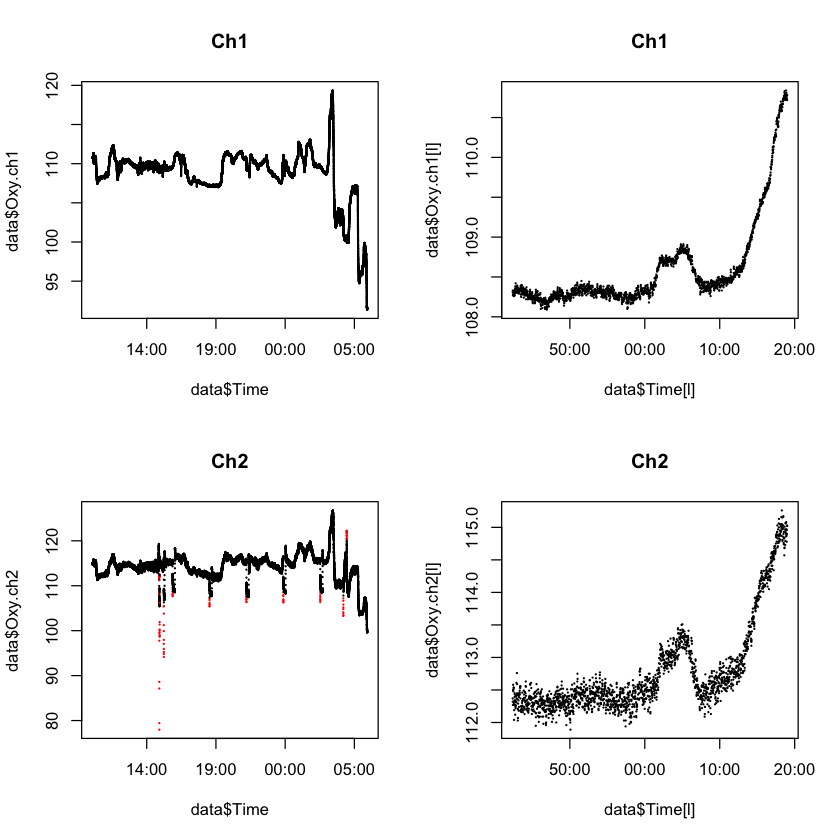

In [7]:
#plot(data$Time, data$Oxy.ch1, type='l')
#lines(data$Time, data$Oxy.ch1.ma, col='red')
par(mfrow=c(2,2))
l = c(2000:4000)

plot(data$Time, data$Oxy.ch1, pch=20, cex=0.2, col = data$Oxy.ch1.flag, main = 'Ch1')
plot(data$Time[l], data$Oxy.ch1[l], pch=20, cex=0.2, col = data$Oxy.ch1.flag[l], main='Ch1')

plot(data$Time, data$Oxy.ch2, pch=20, cex=0.2, col = data$Oxy.ch2.flag, main = 'Ch2')
plot(data$Time[l], data$Oxy.ch2[l], pch=20, cex=0.2, col = data$Oxy.ch2.flag[l], main='Ch2')

## Percentages
ch1 = length(which(data$Oxy.ch1.flag == 2)) / nrow(data)
ch2 = length(which(data$Oxy.ch2.flag == 2)) / nrow(data)

print(paste('Percent removed (Ch1):', floor(ch1*100)))
print(paste('Percent removed (Ch2):', floor(ch2*100)))

[1] "Percent removed (Ch1): 0"
[1] "Percent removed (Ch2): 0"


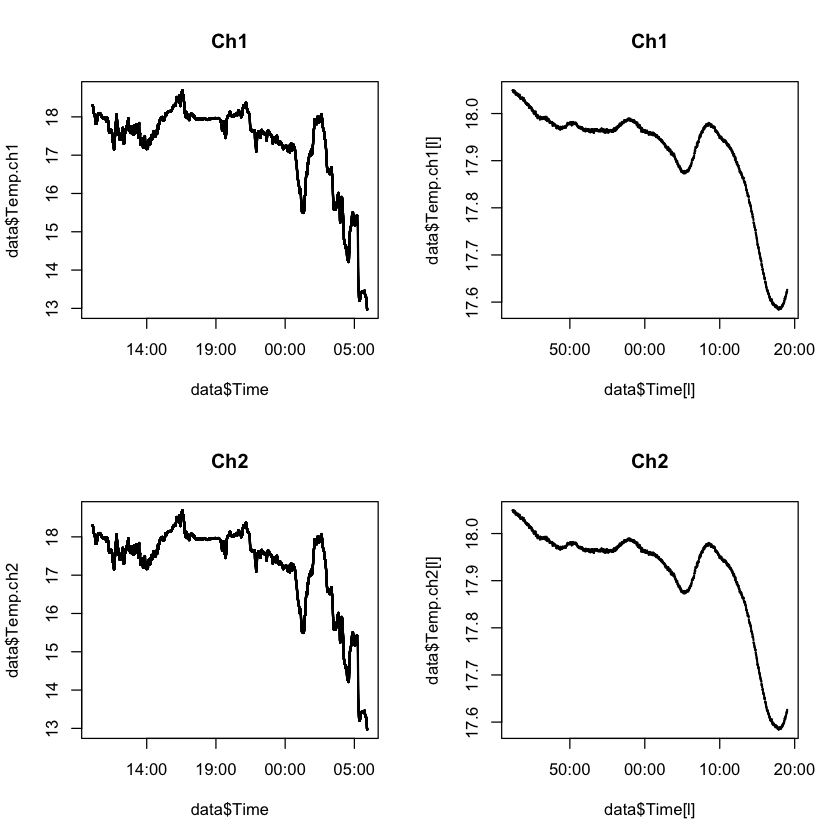

In [8]:
#plot(data$Time, data$Oxy.ch1, type='l')
#lines(data$Time, data$Oxy.ch1.ma, col='red')
par(mfrow=c(2,2))
l = c(2000:4000)

plot(data$Time, data$Temp.ch1, pch=20, cex=0.2, col = data$Temp.ch1.flag, main = 'Ch1')
plot(data$Time[l], data$Temp.ch1[l], pch=20, cex=0.2, col = data$Temp.ch1.flag[l], main='Ch1')

plot(data$Time, data$Temp.ch2, pch=20, cex=0.2, col = data$Temp.ch2.flag, main = 'Ch2')
plot(data$Time[l], data$Temp.ch2[l], pch=20, cex=0.2, col = data$Temp.ch2.flag[l], main='Ch2')

## Percentages
ch1 = length(which(data$Temp.ch1.flag == 2)) / nrow(data)
ch2 = length(which(data$Temp.ch2.flag == 2)) / nrow(data)

print(paste('Percent removed (Ch1):', floor(ch1*100)))
print(paste('Percent removed (Ch2):', floor(ch2*100)))

---
# Automate and run

In [9]:
file.list

[1] "02log.txt"                                              
 [2] "060117-Revelle-1405.txt"                                
 [3] "060217-Revelle-155pm.txt"                               
 [4] "060217-Revelle-446pm.txt"                               
 [5] "060217-Revelle-628pm.txt"                               
 [6] "060317-Revelle-157pm.txt"                               
 [7] "060317-Revelle-814pm.txt"                               
 [8] "060417-Revelle-200pm.txt"                               
 [9] "060417-Revelle-445am.txt"                               
[10] "060517-Revelle-300am.txt"                               
[11] "060517-Revelle-705pm.txt"                               
[12] "060517-Revelle-710pm.txt"                               
[13] "060617-Revelle-300am after calibration.txt"             
[14] "060717-revelle-843pm.txt"                               
[15] "060817-Revelle-423pm.txt"                               
[16] "061017-Revelle-1126am.txt"                              
[17] "061017-Revelle-219am.txt"                               
[18] "061217-Revelle-406am.txt"                               
[19] "061317-Revelle-808am.txt"                               
[20] "061417-Revelle-1144am.txt"                              
[21] "061517-Revelle-525am.txt"                               
[22] "061519-Revelle-705am-start cycle3.txt"                  
[23] "061520-Revelle-238pm.txt"                               
[24] "061617-Revelle-300am- depth profile.txt"                
[25] "061617-Revelle-337pm- depth profile.txt"                
[26] "061717-Revelle-149pm.txt"                               
[27] "061717-Revelle-658pm toward cycle 3.txt"                
[28] "062017-Revelle-500am.txt"                               
[29] "062217-Revelle-1056am after recali and after cycle3.txt"
[30] "062217-Revelle-1200am.txt"                              
[31] "062317-Revelle-117pm end of cycle 3.txt"                
[32] "062417-Revelle-249PM.txt"                               
[33] "062517-Revelle-218PM.txt"                               
[34] "062617-Revelle-1000pm.txt"                              
[35] "062617-Revelle-1234am.txt"                              
[36] "062717-Revelle-450pm.txt"                               
[37] "062817-Revelle-530pm.txt"                               
[38] "062917-Revelle-240pm.txt"                               
[39] "070117-Revelle-440am.txt"                               
[40] "MergedFile.txt"                                         
[41] "rEVELLE-TEST1.txt"                                      
[42] "rEVELLE-TEST2.txt"                                      
[43] "seagrass.txt"                                           
[44] "thallassia.txt"

In [10]:
run = function(input.dir, file.list, write.xlsx = FALSE, output.dir = '', N = 60) {
    data = process.file(input.dir, file.list[5])
    data = add.filter.flags(data)
    try({plot.flags(data, paste0('Output/Optode/', file.list[5], '-.pdf'))})
    data = avg.data(data, N)
    
    if (write.xlsx) {
        write.xlsx(file = paste0(input.dir, output.dir, file.list[1], '-parsed-avg.xlsx'), data)
    }

    for (i in 6:length(file.list)) {
        temp = process.file(input.dir, file.list[i])
        temp = add.filter.flags(temp)
        try({plot.flags(temp, paste0('Output/Optode/', file.list[i], '-.pdf'))})
        temp = avg.data(temp, N)
        
        
        if (write.xlsx) {
            write.xlsx(file = paste0(input.dir, output.dir, file.list[i], '-parsed-avg.xlsx'), temp)
        }

        data = rbind(data, temp)
    }
    ## Return
    data
}

In [ ]:
data = run(input.dir, file.list, N = 10)

In [ ]:
plot(data$Time, data$Oxy.ch1, pch=16, cex=0.2)
points(data$Time, data$Oxy.ch2-25, col='red', pch=16, cex=0.2)
points(data$Time, data$Oxy.ch3-60, col='green', pch=16, cex=0.2)
points(data$Time, data$Oxy.ch4-75, col='blue', pch=16, cex=0.2)

# Save

In [ ]:
optode = data
save(optode, file='RStates/Optode-01.23.18.rdata')

---
# Ancillary Tasks
## Run the parser to generate intermediate input files.

In [ ]:
for (i in file.list[1:length(file.list)]) {
    temp = 0
    try({temp = avg.data(process.file(input.dir, i), 20)})
    write.xlsx(temp, paste0(input.dir, 'avg/', i, '-parsed.xlsx'))
}

In [24]:
temp = process.file(input.dir, file.list[4])
str(temp)

'data.frame':	9275 obs. of  12 variables:
 $ Date    : chr  "6/2/2017" "6/2/2017" "6/2/2017" "6/2/2017" ...
 $ Time    : chr  "09:56:01" "09:56:03" "09:56:04" "09:56:05" ...
 $ Rel.Time: chr  "0" "1.31" "2.4" "3.54" ...
 $ Oxy.ch1 : num  91.1 91.1 91.1 91.1 91.1 ...
 $ Oxy.ch2 : num  99.7 99.7 99.7 99.6 99.6 ...
 $ Oxy.ch3 : chr  "---" "---" "---" "---" ...
 $ Oxy.ch4 : chr  "---" "---" "---" "---" ...
 $ Temp.ch1: num  13 13 13 13 13 ...
 $ Temp.ch2: num  13 13 13 13 13 ...
 $ Temp.ch3: num  20 20 20 20 20 20 20 20 20 20 ...
 $ Temp.ch4: num  20 20 20 20 20 20 20 20 20 20 ...
 $ Pressure: num  1013 1013 1013 1013 1013 ...


## Helper scripts for data parsing (misc)

In [67]:
parse.to.csv = function(input.dir, file) {
    data = data.frame(text = '', stringsAsFactors = FALSE)
    con = file(paste0(input.dir, file), "r")
    while ( TRUE ) {
        line = readLines(con, n = 1)
        if ( length(line) == 0 ) {
          break
        }
        data = rbind(data, gsub("\t", ",", line))
      }
    write.table(data, file = paste0(input.dir, 'csv/', file, '.csv'), row.names = FALSE,
                col.names = FALSE, quote = FALSE)
    close(con)
}

In [68]:
for (i in file.list) {
    parse.to.csv(input.dir, i)
}

Warning message in readLines(con, n = 1):
"incomplete final line found on 'Raw Data/O2-optode MIMS/060217-Revelle-155pm.txt'"Warning message in readLines(con, n = 1):
"incomplete final line found on 'Raw Data/O2-optode MIMS/060217-Revelle-446pm.txt'"Warning message in readLines(con, n = 1):
"incomplete final line found on 'Raw Data/O2-optode MIMS/060217-Revelle-628pm.txt'"Warning message in readLines(con, n = 1):
"incomplete final line found on 'Raw Data/O2-optode MIMS/060317-Revelle-157pm.txt'"

# Save output file

In [8]:
optode = as.data.frame(read.xlsx('Raw Data/O2-optode MIMS/avg/_merge-chrono.xlsx'))
colnames(optode) = c('File', 'Date', 'Starttime', 'Endtime', 'Reltime', 'Oxy1', 'Oxy2', 'Oxy3', 'Oxy4',
                     'T1', 'T2', 'T3', 'T4', 'Pressure')

optode$Starttime = conv_excel_time(optode$Starttime, tz = 'GMT')
optode$Endtime = conv_excel_time(optode$Endtime, tz = 'GMT')
str(optode)

'data.frame':	126206 obs. of  14 variables:
 $ File     : chr  "Macintosh HD:Users:Sven:Dropbox:CCE-shipdata:MIMS-TBK:Raw Data:O2-optode MIMS:avg:060117-1-Revelle-1405.txt-parsed.xlsx" "Macintosh HD:Users:Sven:Dropbox:CCE-shipdata:MIMS-TBK:Raw Data:O2-optode MIMS:avg:060117-1-Revelle-1405.txt-parsed.xlsx" "Macintosh HD:Users:Sven:Dropbox:CCE-shipdata:MIMS-TBK:Raw Data:O2-optode MIMS:avg:060117-1-Revelle-1405.txt-parsed.xlsx" "Macintosh HD:Users:Sven:Dropbox:CCE-shipdata:MIMS-TBK:Raw Data:O2-optode MIMS:avg:060117-1-Revelle-1405.txt-parsed.xlsx" ...
 $ Date     : num  42887 42887 42887 42887 42887 ...
 $ Starttime: POSIXct, format: "2017-06-01 06:05:59" "2017-06-01 06:06:18" ...
 $ Endtime  : POSIXct, format: "2017-06-01 10:05:44" "2017-06-01 10:06:04" ...
 $ Reltime  : num  29.2 49.3 69.9 90 109.9 ...
 $ Oxy1     : num  111 111 111 111 111 ...
 $ Oxy2     : num  115 115 115 115 115 ...
 $ Oxy3     : num  NA NA NA NA NA NA NA NA NA NA ...
 $ Oxy4     : num  NA NA NA NA NA NA NA NA NA NA

In [10]:
save(optode, file = 'RStates/Optode 12.04.17.rdata')